# PCA
PCA steps for data downscaling projet, dominant PCs to be exported in an array since that is all we really work with in the main downscalling file (in an effort to reduce memory load)<br>

World data preprocessing in this file because i didnt feel as if a new netCDF file was necessary for that data as it already loads rather quickly and doesn't take up much space

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import xarray as xr
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
#load in HRDPS and world data (for now still just working on pressure)
P_world= xr.open_mfdataset(["psl_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20110101-20151231.nc", "psl_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc"])
U_world= xr.open_mfdataset(["uas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20110101-20151231.nc", "uas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc"])
V_world= xr.open_mfdataset(["vas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20110101-20151231.nc", "vas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc"])
hrdps = xr.open_dataset("hrdps_day_avgs_postSep2014.nc")

#lets go ahead and trim the hrdps dataset so it fits more snuggly in a year
#we're also going to remove the leap days here so that seasonal cycle calcs will work
a= hrdps.sel(time_counter=slice('2015-01-01T00:00:00.000000000', '2016-02-28T00:00:00.000000000'))
b= hrdps.sel(time_counter=slice('2016-03-01T00:00:00.000000000', '2020-02-28T00:00:00.000000000'))
c= hrdps.sel(time_counter=slice('2020-03-01T00:00:00.000000000', '2020-12-31T00:00:00.000000000'))
hrdps= xr.concat([a,b,c],dim='time_counter')

## Preprocessing on HRDPS

In [3]:
hrdps_lat = hrdps.nav_lat.sel(time_counter=hrdps.time_counter[0]).values.flatten()
hrdps_lon = hrdps.nav_lon.sel(time_counter=hrdps.time_counter[0]).values.flatten()
p_temp = hrdps.atmpres.values
u= hrdps.u_wind.values
v = hrdps.v_wind.values

In [4]:
#want to work with speed and direc, not U and V
speed_temp = np.sqrt(np.add(np.square(u),np.square(v)))
direc_temp = np.arctan2(u,v)

In [5]:
#export the hrdps lat and lon
# np.savetxt("hrdps_lat.csv", hrdps_lat, delimiter=",")
# np.savetxt("hrdps_lon.csv", hrdps_lon, delimiter=",")

In [6]:
#get pressure into a shape we can work in
P_hrdps = np.empty((np.shape(p_temp)[1]*np.shape(p_temp)[2],np.shape(p_temp)[0]))
for i in range(np.shape(p_temp)[0]):
    P_hrdps[:,i] = np.reshape(p_temp[i],(np.shape(p_temp)[1]*np.shape(p_temp)[2],))
print(f"cummulative time -pressure done (s):"+str(time.time()))
    
speed_hrdps = np.empty((np.shape(speed_temp)[1]*np.shape(speed_temp)[2],np.shape(speed_temp)[0]))
for i in range(np.shape(speed_temp)[0]):
    speed_hrdps[:,i] = np.reshape(speed_temp[i],(np.shape(speed_temp)[1]*np.shape(speed_temp)[2],))
print(f"cummulative time wind speed done (s):"+str(time.time()))
    
direc_hrdps = np.empty((np.shape(direc_temp)[1]*np.shape(direc_temp)[2],np.shape(direc_temp)[0]))
for i in range(np.shape(direc_temp)[0]):
    direc_hrdps[:,i] = np.reshape(direc_temp[i],(np.shape(direc_temp)[1]*np.shape(direc_temp)[2],))
print(f"cummulative time wind direction done (s):"+str(time.time()))

cummulative time -pressure done (s):1611953335.1210542
cummulative time wind speed done (s):1611953336.8171754
cummulative time wind direction done (s):1611953338.4931207


In [7]:
#replace all nan with 101325 or 0
P_hrdps = (pd.DataFrame(P_hrdps).fillna(101325)).to_numpy()
speed_hrdps = (pd.DataFrame(speed_hrdps).fillna(0)).to_numpy()
direc_hrdps = (pd.DataFrame(direc_hrdps).fillna(0)).to_numpy()

In [8]:
#now de-mean the dataset (If the mean isn't removed then it will show up in the mode 1 EOF and give disproportionate weight to the mode 1 percent variance)
#calculate seasonal signal for each grid point

nyears = 6

#pressure
seasonal = np.empty((np.shape(P_hrdps)[0],365))
for ii in range(len(P_hrdps)):
    seasonal[ii,:] = np.mean(np.reshape(P_hrdps[ii,:],(nyears,365)),axis=0)

#repeat the seasonal cycle for all years
seasonal_all = np.tile(seasonal,(1,nyears))
np.savetxt("P_daily_seasonal.csv", seasonal, delimiter=",")

#remove seasonal cycle from the original data (calculate anomalies)
P_hrdps_anom = P_hrdps - seasonal_all

#speed wind
seasonal = np.empty((np.shape(speed_hrdps)[0],365))
for ii in range(len(speed_hrdps)):
    seasonal[ii,:] = np.mean(np.reshape(speed_hrdps[ii,:],(nyears,365)),axis=0)

#repeat the seasonal cycle for all years
seasonal_all = np.tile(seasonal,(1,nyears))
np.savetxt("speed_daily_seasonal.csv", seasonal, delimiter=",")

#remove seasonal cycle from the original data (calculate anomalies)
speed_hrdps_anom = speed_hrdps - seasonal_all

#V-wind
seasonal = np.empty((np.shape(direc_hrdps)[0],365))
for ii in range(len(direc_hrdps)):
    seasonal[ii,:] = np.mean(np.reshape(direc_hrdps[ii,:],(nyears,365)),axis=0)

#repeat the seasonal cycle for all years
seasonal_all = np.tile(seasonal,(1,nyears))
np.savetxt("direc_daily_seasonal.csv", seasonal, delimiter=",")

#remove seasonal cycle from the original data (calculate anomalies)
direc_hrdps_anom = direc_hrdps - seasonal_all

## Preprocessing CanRCM4

In [3]:
#now for preprocessing of world data
#trim the world dataset to be for right time extent
#want days between September 12 2014 and December 31 2020
P_world = P_world.sel(time=slice('2014-01-01 12:00:00', '2020-12-31 12:00:00'))
U_world = U_world.sel(time=slice('2014-01-01 12:00:00', '2020-12-31 12:00:00'))
V_world = V_world.sel(time=slice('2014-01-01 12:00:00', '2020-12-31 12:00:00'))

In [8]:
#now extract the data you want from the CanRCM4 xarray and trim them according to lat and lon of the HRDPS data
#first decide on range you want to work within for CanRCM4 data, want to overlap the HRDPS data by 10% of the max distance (y)
maxlon = max(hrdps_lon)
minlon = min(hrdps_lon)
maxlat = max(hrdps_lat)
minlat = min(hrdps_lat)

buffer = (maxlat-minlat)*0.15

lon = P_world.lon.values.flatten()
lat = P_world.lat.values.flatten()

index = []

#first find idexes that fit into lon range and lat range
for i in range(len(lon)):
    if lon[i] > (minlon-buffer) and lon[i] < (maxlon+buffer) and lat[i] > (minlat-buffer) and lat[i] < (maxlat+buffer):
        index.append(i)

#now make new lat, and lon
lat_RCM = []
lon_RCM = []

for i in index:
    lat_RCM.append(lat[i])
    lon_RCM.append(lon[i])

In [20]:
#export the RCM lat and lon
np.savetxt("RCM_lat.csv", lat_RCM, delimiter=",")
np.savetxt("RCM_lon.csv", lon_RCM, delimiter=",")

In [5]:
#load the data before trying to process it
P = P_world.psl.values
U = U_world.uas.values
V = V_world.vas.values

In [6]:
#now convert data to 2D
start = time.time()
P2d = np.empty((len(P_world.rlat)*len(P_world.rlon),len(P_world.time)))
               
for i in range(len(P_world.time)):
    P2d[:,i] = np.reshape(P[i],(len(P_world.rlat)*len(P_world.rlon),))
print(f"time -pressure done (s):"+str(time.time()-start))

               
start = time.time()
U2d = np.empty((len(U_world.rlat)*len(U_world.rlon),len(U_world.time)))
               
for i in range(len(U_world.time)):
    U2d[:,i] = np.reshape(U[i],(len(U_world.rlat)*len(U_world.rlon),))
print(f"time -U wind done (s):"+str(time.time()-start))

               
start = time.time()
V2d = np.empty((len(V_world.rlat)*len(V_world.rlon),len(V_world.time)))
               
for i in range(len(V_world.time)):
    V2d[:,i] = np.reshape(V[i],(len(V_world.rlat)*len(V_world.rlon),))
print(f"time -V wind done (s):"+str(time.time()-start))

time -pressure done (s):4.653015613555908
time -U wind done (s):4.43390154838562
time -V wind done (s):5.439693927764893


In [7]:
# np.savetxt("RCM_Uwinds.csv", U2d, delimiter=",")
# np.savetxt("RCM_Vwinds.csv", V2d, delimiter=",")

In [13]:
#use indices found in lat-lon step to trim CanRCM4 extent

P_RCM = np.empty((len(index),len(P_world.time)))

for i in range(len(P_world.time)):
    for j in range(len(index)):
        P_RCM[j,i] = P2d[index[j],i]
        
U_RCM = np.empty((len(index),len(U_world.time)))

for i in range(len(U_world.time)):
    for j in range(len(index)):
        U_RCM[j,i] = U2d[index[j],i]
        
V_RCM = np.empty((len(index),len(V_world.time)))

for i in range(len(V_world.time)):
    for j in range(len(index)):
        V_RCM[j,i] = V2d[index[j],i]


In [14]:
#remove seasonal cycle
nyears = 7

#pressure
seasonal = np.empty((np.shape(P_RCM)[0],365))
for ii in range(len(P_RCM)):
    seasonal[ii,:] = np.mean(np.reshape(P_RCM[ii,:],(nyears,365)),axis=0)

#repeat the seasonal cycle for all years
seasonal_all = np.tile(seasonal,(1,nyears))

#remove seasonal cycle from the original data (calculate anomalies)
P_RCM_anom = P_RCM - seasonal_all

#U-wind
seasonal = np.empty((np.shape(U_RCM)[0],365))
for ii in range(len(U_RCM)):
    seasonal[ii,:] = np.mean(np.reshape(U_RCM[ii,:],(nyears,365)),axis=0)

#repeat the seasonal cycle for all years
seasonal_all = np.tile(seasonal,(1,nyears))

#remove seasonal cycle from the original data (calculate anomalies)
U_RCM_anom = U_RCM - seasonal_all

#V-wind
seasonal = np.empty((np.shape(V_RCM)[0],365))
for ii in range(len(V_RCM)):
    seasonal[ii,:] = np.mean(np.reshape(V_RCM[ii,:],(nyears,365)),axis=0)

#repeat the seasonal cycle for all years
seasonal_all = np.tile(seasonal,(1,nyears))

#remove seasonal cycle from the original data (calculate anomalies)
V_RCM_anom = V_RCM - seasonal_all

## PCA
NOTE : before export find out how to limit range of the PCs so that you don't need to normalize afterwords

In [15]:
#PCA on the world data
#looking for dominant spatial patterns to be eigenvectors and how those spatial patterns evelove over the month to the the PCs)
#need to take the transpose of the matrix 

data = P_RCM_anom.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
P_RCM_PCs = pca.fit_transform(data)
P_RCM_eigvecs = pca.components_
P_RCM_fracVar = pca.explained_variance_ratio_

data = U_RCM_anom.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
U_RCM_PCs = pca.fit_transform(data)
U_RCM_eigvecs = pca.components_
U_RCM_fracVar = pca.explained_variance_ratio_

data = V_RCM_anom.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
V_RCM_PCs = pca.fit_transform(data)
V_RCM_eigvecs = pca.components_
V_RCM_fracVar = pca.explained_variance_ratio_

In [16]:
#export the relevant arrays to CSV
# np.savetxt("P_RCM_PCs.csv", P_RCM_PCs, delimiter=",")
# np.savetxt("P_RCM_eigvecs.csv", P_RCM_eigvecs, delimiter=",")
# np.savetxt("P_RCM_fracVar.csv", P_RCM_fracVar, delimiter=",")

# np.savetxt("U_RCM_PCs.csv", U_RCM_PCs, delimiter=",")
# np.savetxt("U_RCM_eigvecs.csv", U_RCM_eigvecs, delimiter=",")
# np.savetxt("U_RCM_fracVar.csv", U_RCM_fracVar, delimiter=",")

# np.savetxt("V_RCM_PCs.csv", V_RCM_PCs, delimiter=",")
# np.savetxt("V_RCM_eigvecs.csv", V_RCM_eigvecs, delimiter=",")
# np.savetxt("V_RCM_fracVar.csv", V_RCM_fracVar, delimiter=",")

In [9]:
#PCA on the HRDPS data 
data = P_hrdps_anom.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
hrdps_PCs = pca.fit_transform(data)
hrdps_eigvecs = pca.components_
hrdps_fracVar = pca.explained_variance_ratio_

#export the relevant arrays to CSV
# np.savetxt("P_hrdps_PCs.csv", hrdps_PCs, delimiter=",")
# np.savetxt("P_hrdps_eigvecs.csv", hrdps_eigvecs, delimiter=",")
# np.savetxt("P_hrdps_fracVar.csv", hrdps_fracVar, delimiter=",")

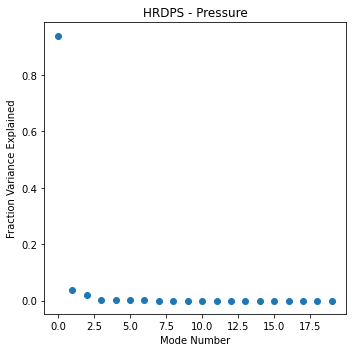

In [10]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(hrdps_fracVar[0:20])),hrdps_fracVar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('HRDPS - Pressure')

plt.tight_layout()

plt.show()

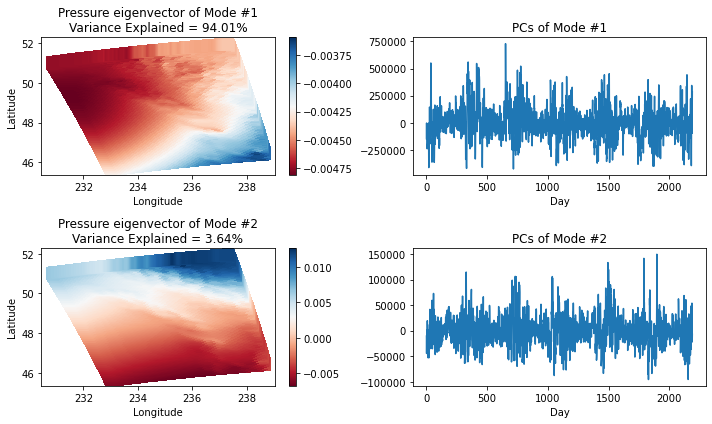

In [11]:
#lets look at the first 2 modes
n = 2

plt.figure(figsize=(10,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = hrdps_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 133,
            marker = 's')
    plt.title('Pressure eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(hrdps_fracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

In [12]:
data = speed_hrdps_anom.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
hrdps_PCs = pca.fit_transform(data)
hrdps_eigvecs = pca.components_
hrdps_fracVar = pca.explained_variance_ratio_

#export the relevant arrays to CSV
# np.savetxt("speed_hrdps_PCs.csv", hrdps_PCs, delimiter=",")
# np.savetxt("speed_hrdps_eigvecs.csv", hrdps_eigvecs, delimiter=",")
# np.savetxt("speed_hrdps_fracVar.csv", hrdps_fracVar, delimiter=",")

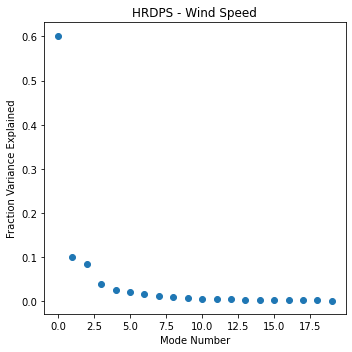

In [13]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(hrdps_fracVar[0:20])),hrdps_fracVar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('HRDPS - Wind Speed')

plt.tight_layout()

plt.show()

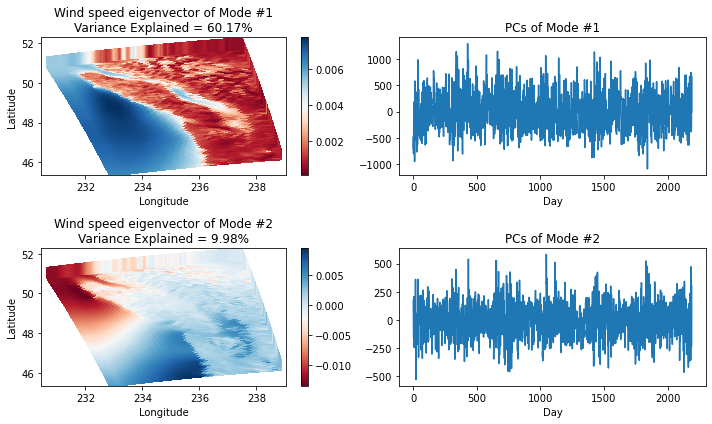

In [14]:
#lets look at the first 2 modes
n = 2

plt.figure(figsize=(10,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = hrdps_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 133,
            marker = 's')
    plt.title('Wind speed eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(hrdps_fracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

In [15]:
data = direc_hrdps_anom.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
hrdps_PCs = pca.fit_transform(data)
hrdps_eigvecs = pca.components_
hrdps_fracVar = pca.explained_variance_ratio_

#export the relevant arrays to CSV
# np.savetxt("direc_hrdps_PCs.csv", hrdps_PCs, delimiter=",")
# np.savetxt("direc_hrdps_eigvecs.csv", hrdps_eigvecs, delimiter=",")
# np.savetxt("direc_hrdps_fracVar.csv", hrdps_fracVar, delimiter=",")

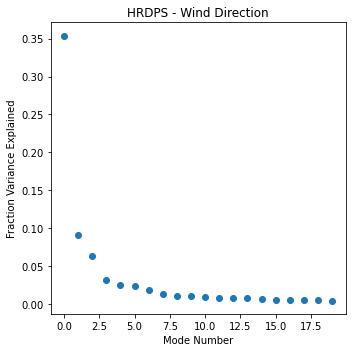

In [16]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(hrdps_fracVar[0:20])),hrdps_fracVar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('HRDPS - Wind Direction')

plt.tight_layout()

plt.show()

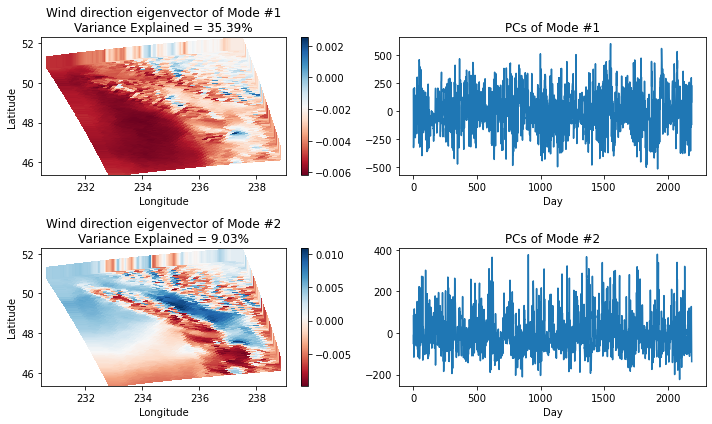

In [17]:
#lets look at the first 2 modes
n = 2

plt.figure(figsize=(10,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = hrdps_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 133,
            marker = 's')
    plt.title('Wind direction eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(hrdps_fracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

In [14]:
#save date arrays that you want to work with
# dates = P_world.time.values
# np.savetxt("RCM_dates.csv",dates,delimiter=",",fmt="%s")
# dates = hrdps.time_counter.values
# np.savetxt("hrdps_dates.csv",dates,delimiter=",",fmt="%s")